In [1]:
import glob
import os
import json
import nibabel as nib
from skimage.metrics import structural_similarity as ssim
import numpy as np
import tensorflow as tf
from skimage.exposure import rescale_intensity
import pandas as pd
import datetime

In [2]:
# T1_root_path = r'E:\Graduation Project\Datasets\T1 Synthesized BraTS Validation Brain Cropped'
# T2_root_path = r'E:\Graduation Project\Datasets\T2 Synthesized BraTS Validation Brain Cropped'
# root_path = r'E:\Graduation Project\Datasets\BraTS Validation Brain Cropped'

T1_root_path = r'E:\Graduation Project\Datasets\T1-FLAIR Archive\ResNet4(259 ep) - T1 Synth from FLAIR - BraTS Validation - Brain Cropped'
T2_root_path = r'E:\Graduation Project\Datasets\T1-FLAIR Archive\ResNet4(259 ep) - FLAIR Synth from T1 - BraTS Validation - Brain Cropped'
root_path = r'E:\Graduation Project\Datasets\BraTS Validation Brain Cropped'


data_list = sorted(glob.glob(root_path + '/*'))                            
T1_data_list = sorted(glob.glob(T1_root_path + '/*'))                            
T2_data_list = sorted(glob.glob(T2_root_path + '/*'))                            

T1_T2_SSIM = []
T2_T1_SSIM = []

True_T1_paths = []
True_T2_paths = []
Synth_T1_paths = []
Synth_T2_paths = []

import json

# Read the contents of the file
with open('validation.txt', 'r') as file:
    contents = file.read()

# Replace single quotes with double quotes
contents = contents.replace("'", "\"")

# Load the JSON array
validation_names = json.loads(contents)

In [3]:
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.endswith('t1.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            True_T1_paths.append(file_path)

for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            True_T2_paths.append(file_path)

for dirpath, dirnames, filenames in os.walk(T1_root_path):
    for filename in filenames:
        if filename.endswith('t1.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            Synth_T1_paths.append(file_path)

for dirpath, dirnames, filenames in os.walk(T2_root_path):
    for filename in filenames:
        if filename.endswith('flair.nii.gz'):
            file_path = os.path.join(dirpath, filename)
            Synth_T2_paths.append(file_path)

In [7]:
# calculate the SSIM score for each slice of each pair of volumes
def calc_2D_tf_SSIM(Synth_paths, True_paths):
    SSIM_tf_2D = []
    for path1, path2 in zip(Synth_paths, True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()
        vol1 = rescale_intensity(vol1, out_range=(0, 1))
        vol2 = rescale_intensity(vol2, out_range=(0, 1))

        # calculate the SSIM score for each slice
        ssim_scores_vol = []

        for i in range(vol1.shape[2]):
            slice1 = vol1[:, :, i]
            slice2 = vol2[:, :, i]

            slice1 = np.stack([slice1]*3, axis=-1)
            slice2 = np.stack([slice2]*3, axis=-1)

            ssim_score = tf.image.ssim(slice1, slice2, max_val=1)
            ssim_scores_vol.append(ssim_score)


        # calculate the average SSIM score for the volume
        avg_ssim_vol = np.mean(ssim_scores_vol)

        # add the average SSIM scores to the list
        SSIM_tf_2D.append(avg_ssim_vol)
        
    return SSIM_tf_2D

def _calculate_mae_mse(arr1, arr2):
    diff = arr1 - arr2
    mae = np.mean(np.abs(diff))
    mse = np.mean(diff ** 2)
    return mae, mse

def calculate_mae_mse(T1_Synth_paths, T1_True_paths, norm_range):
    MAE, MSE = [], []
    for path1, path2 in zip(T1_Synth_paths, T1_True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()

        vol1 = rescale_intensity(vol1, out_range=norm_range)
        vol2 = rescale_intensity(vol2, out_range=norm_range)
        
        mae, mse = _calculate_mae_mse(vol1, vol2)

        MAE.append(mae)
        MSE.append(mse)
    return MAE, MSE

def psnr(Synth_paths, True_paths):
    """
    Calculate the average PSNR between corresponding slices of two 3D volumes.
    """
    PSNR = []
    for path1, path2 in zip(Synth_paths, True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()
        vol1 = rescale_intensity(vol1, out_range=(0, 1))
        vol2 = rescale_intensity(vol2, out_range=(0, 1))

        psnrs = []
        for i in range(vol1.shape[2]):
            mse = np.mean((vol1[:,:,i] - vol2[:,:,i]) ** 2)
            if mse == 0:
                psnrs.append(float('inf'))
            else:
                max_pixel = np.max(vol1[:,:,i])
                psnrs.append(20 * np.log10(max_pixel / np.sqrt(mse)))
        avg_psnr = np.mean(psnrs)
        PSNR.append(avg_psnr)
    return PSNR

In [8]:
a = datetime.datetime.now()
SSIM_2D_T1_Synth_from_T2 = calc_2D_tf_SSIM(Synth_T1_paths, True_T1_paths)
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
SSIM_2D_T2_Synth_from_T1 = calc_2D_tf_SSIM(Synth_T2_paths, True_T2_paths)
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
MAE_T1_Synth_from_T2_0_1, MSE_T1_Synth_from_T2_0_1 = calculate_mae_mse(Synth_T1_paths, True_T1_paths, norm_range=(0, 1))
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
MAE_T2_Synth_from_T1_0_1, MSE_T2_Synth_from_T1_0_1 = calculate_mae_mse(Synth_T2_paths, True_T2_paths, norm_range=(0, 1))
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
MAE_T1_Synth_from_T2_neg1_1, MSE_T1_Synth_from_T2_neg1_1 = calculate_mae_mse(Synth_T1_paths, True_T1_paths, norm_range=(-1, 1))
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
MAE_T2_Synth_from_T1_neg1_1, MSE_T2_Synth_from_T1_neg1_1 = calculate_mae_mse(Synth_T2_paths, True_T2_paths, norm_range=(-1, 1))
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)

a = datetime.datetime.now()
PSNR_T1_Synth_from_T2 = psnr(Synth_T1_paths, True_T1_paths)
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)


a = datetime.datetime.now()
PSNR_T2_Synth_from_T1 = psnr(Synth_T2_paths, True_T2_paths)
b = datetime.datetime.now()
delta = b - a
print(delta.total_seconds()/60)

7.487335466666667
7.721034933333333
1.4126059666666668
1.4039133
1.3870804666666667
1.8649012166666668
1.64314905
1.3908545333333333


In [9]:
# Create a DataFrame from the lists
df = pd.DataFrame({
    "Validation Set": validation_names,
    'SSIM - T1 Synth from FLAIR': SSIM_2D_T1_Synth_from_T2,
    'SSIM - FLAIR Synth from T1': SSIM_2D_T2_Synth_from_T1,
    'MAE - T1 Synth from FLAIR': MAE_T1_Synth_from_T2_0_1,
    'MAE - FLAIR Synth from T1': MAE_T2_Synth_from_T1_0_1,
    'MSE - T1 Synth from FLAIR': MSE_T1_Synth_from_T2_0_1,
    'MSE - FLAIR Synth from T1': MSE_T2_Synth_from_T1_0_1,
    'PSNR - T1 Synth from FLAIR': PSNR_T1_Synth_from_T2,
    'PSNR - FLAIR Synth from T1': PSNR_T2_Synth_from_T1
})

# Save the DataFrame to a CSV file
df.to_csv('E:\Graduation Project\Metrics\T1-FLAIR ResNet-4 Metrics.csv', index=False)

# Visualization

In [16]:
data.iloc[:, 1:3]

,SSIM - T1 Synth from T2,SSIM - T2 Synth from T1
0,0.691392,0.665454
1,0.637079,0.537588
2,0.686947,0.672093
3,0.751269,0.664899
4,0.690159,0.637951
...,...,...
246,0.720772,0.687872
247,0.670113,0.675304
248,0.598762,0.593579
249,0.689356,0.656774


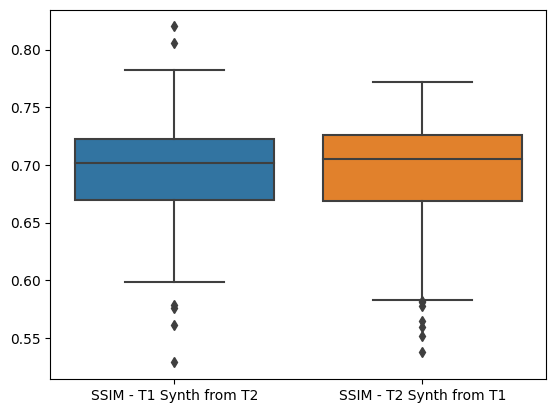

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the csv file
data = pd.read_csv('E:\Graduation Project\Validation Metrics.csv')
# # Create box plots
sns.boxplot(data=data.iloc[:, 1:3], orient='v'); # for T1 Synth from T2 and T2 Synth from T1

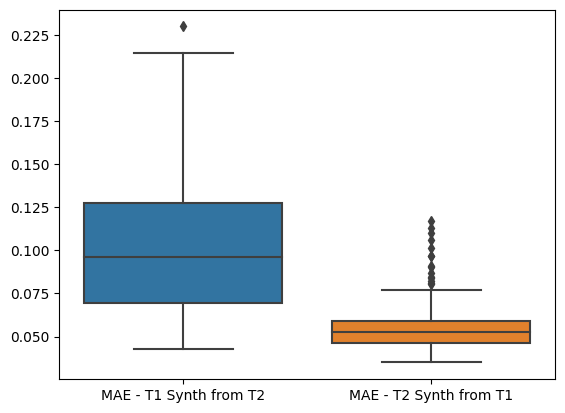

In [28]:
sns.boxplot(data=data.iloc[:, 3:5], orient='v'); # for T1 Synth from T2 and T2 Synth from T1

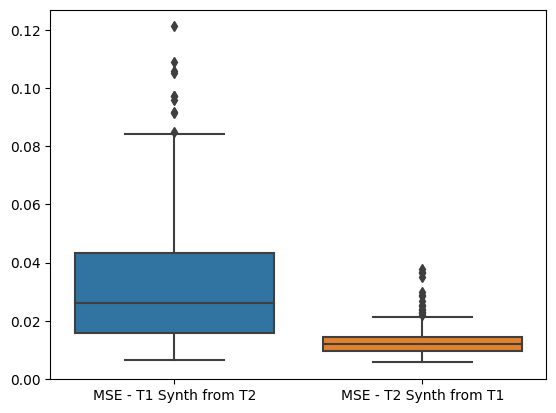

In [29]:
sns.boxplot(data=data.iloc[:, 5:7], orient='v'); # for T1 Synth from T2 and T2 Synth from T1

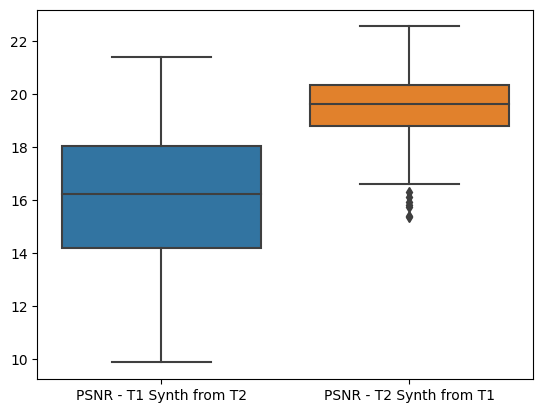

In [34]:
sns.boxplot(data=data.iloc[:, 7:], orient='v'); # for T1 Synth from T2 and T2 Synth from T1

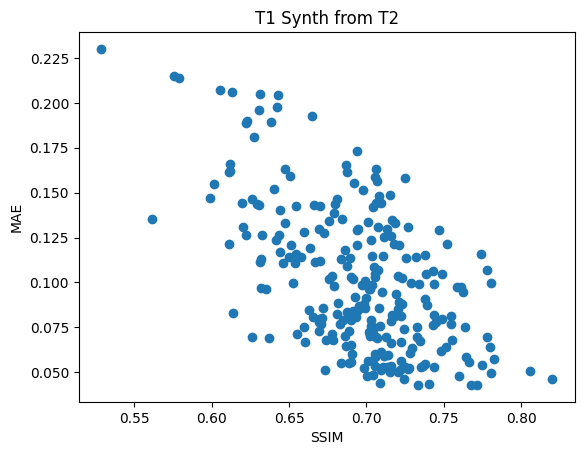

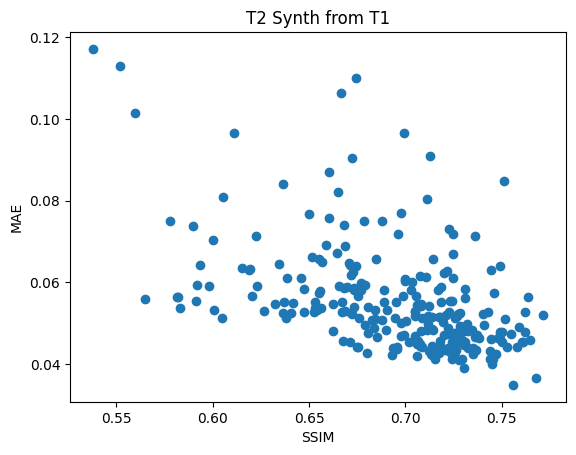

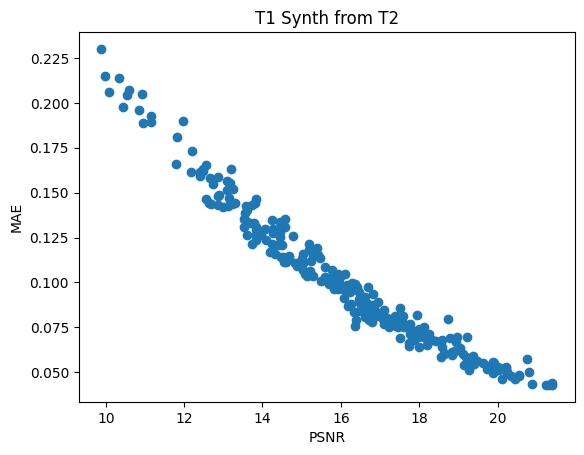

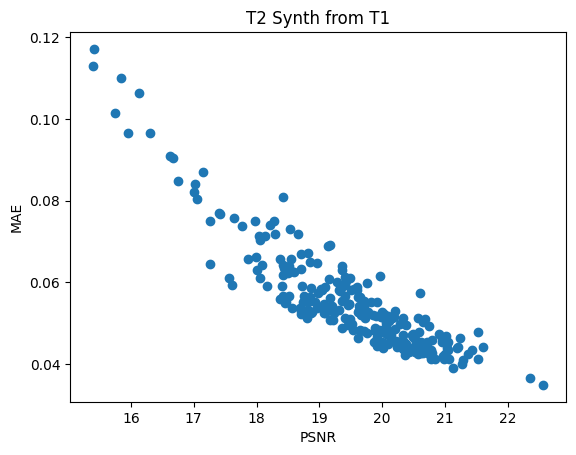

In [40]:
# Load the data from the csv file
data = pd.read_csv('E:\Graduation Project\Validation Metrics.csv')

# Create scatter plots
plt.scatter(data['SSIM - T1 Synth from T2'], data['MAE - T1 Synth from T2'])
plt.xlabel('SSIM')
plt.ylabel('MAE')
plt.title('T1 Synth from T2')
plt.show()

plt.scatter(data['SSIM - T2 Synth from T1'], data['MAE - T2 Synth from T1'])
plt.xlabel('SSIM')
plt.ylabel('MAE')
plt.title('T2 Synth from T1')
plt.show()

plt.scatter(data['PSNR - T1 Synth from T2'], data['MAE - T1 Synth from T2'])
plt.xlabel('PSNR')
plt.ylabel('MAE')
plt.title('T1 Synth from T2')
plt.show()

plt.scatter(data['PSNR - T2 Synth from T1'], data['MAE - T2 Synth from T1'])
plt.xlabel('PSNR')
plt.ylabel('MAE')
plt.title('T2 Synth from T1')
plt.show()

<AxesSubplot: >

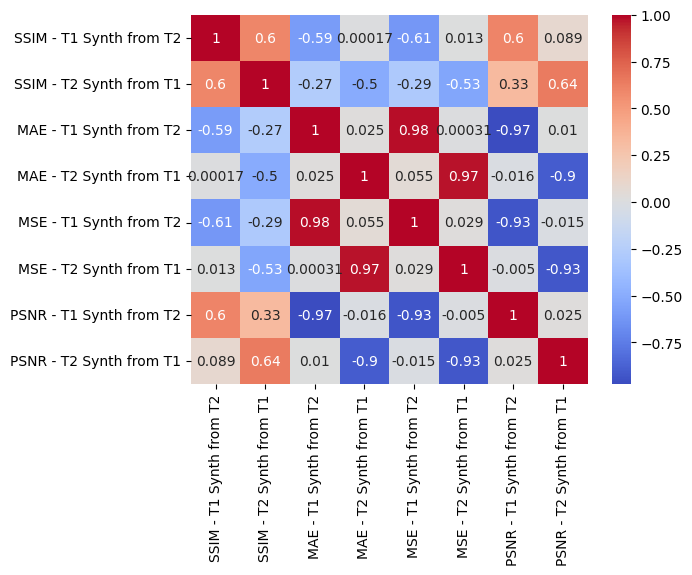

In [57]:
# Load the data from the csv file
data = pd.read_csv('E:\Graduation Project\Validation Metrics.csv')
data = data.iloc[:, 1:]

# Create heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

# For SSIM 2D-3D Skimage VS TF comparison

# Normalzation from 0 to 255

In [13]:
# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_2D = []
T1_T2_SSIM_sk_2D = []
T1_T2_SSIM_sk_2D_rgb = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    vol1 = rescale_intensity(vol1, out_range=(0, 255))
    vol2 = rescale_intensity(vol2, out_range=(0, 255))
    
    # calculate the SSIM score for each slice
    ssim_scores_vol = []
    ssim_scores_vol_2 = []
    ssim_scores_vol_3 = []

    for i in range(vol1.shape[2]):
        slice1 = vol1[:, :, i]
        slice2 = vol2[:, :, i]
        
        ssim_score = ssim(slice1, slice2, data_range=255)
        ssim_scores_vol_2.append(ssim_score)
        
        slice1 = np.stack([slice1]*3, axis=-1)
        slice2 = np.stack([slice2]*3, axis=-1)
        
        ssim_score = tf.image.ssim(slice1, slice2, max_val=255)
        ssim_scores_vol.append(ssim_score)
    
#         print(slice1.shape)
#         ssim_score = ssim(slice1, slice2, data_range=255)
#         ssim_scores_vol_3.append(ssim_score)
    
    # calculate the average SSIM score for the volume
    avg_ssim_vol = np.mean(ssim_scores_vol)
    avg_ssim_vol_2 = np.mean(ssim_scores_vol_2)
#     avg_ssim_vol_3 = np.mean(ssim_scores_vol_3)

    # add the average SSIM scores to the list
    T1_T2_SSIM_tf_2D.append(avg_ssim_vol)
    T1_T2_SSIM_sk_2D.append(avg_ssim_vol_2)
#     T1_T2_SSIM_sk_2D_rgb.append(avg_ssim_vol_3)

# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_3D = []
T1_T2_SSIM_sk_3D = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    
    vol1 = rescale_intensity(vol1, out_range=(0, 255))
    vol2 = rescale_intensity(vol2, out_range=(0, 255))
    
    ssim_score = tf.image.ssim(vol1, vol2, max_val=255)
    ssim_score_2 = ssim(vol1, vol2, data_range=255)
    
    T1_T2_SSIM_tf_3D.append(ssim_score)
    T1_T2_SSIM_sk_3D.append(ssim_score_2)
    

# Create a DataFrame from the lists
df = pd.DataFrame({
    'T1_T2_SSIM_tf_3D': np.array(T1_T2_SSIM_tf_3D),
    'T1_T2_SSIM_sk_3D': T1_T2_SSIM_sk_3D,
    'T1_T2_SSIM_sk_2D': T1_T2_SSIM_sk_2D,
    'T1_T2_SSIM_tf_2D': T1_T2_SSIM_tf_2D
})

# Save the DataFrame to a CSV file
df.to_csv('SSIM 2D-3D Skimage VS TF comparison.csv', index=False)

# Normalzation from 0 to 1

In [7]:
# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_2D = []
T1_T2_SSIM_sk_2D = []
T1_T2_SSIM_sk_2D_rgb = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    vol1 = rescale_intensity(vol1, out_range=(0, 1))
    vol2 = rescale_intensity(vol2, out_range=(0, 1))
    
    # calculate the SSIM score for each slice
    ssim_scores_vol = []
    ssim_scores_vol_2 = []
    ssim_scores_vol_3 = []

    for i in range(vol1.shape[2]):
        slice1 = vol1[:, :, i]
        slice2 = vol2[:, :, i]
        
        ssim_score = ssim(slice1, slice2, data_range=1)
        ssim_scores_vol_2.append(ssim_score)
        
        slice1 = np.stack([slice1]*3, axis=-1)
        slice2 = np.stack([slice2]*3, axis=-1)
        
        ssim_score = tf.image.ssim(slice1, slice2, max_val=1)
        ssim_scores_vol.append(ssim_score)
    
#         print(slice1.shape)
#         ssim_score = ssim(slice1, slice2, data_range=255)
#         ssim_scores_vol_3.append(ssim_score)
    
    # calculate the average SSIM score for the volume
    avg_ssim_vol = np.mean(ssim_scores_vol)
    avg_ssim_vol_2 = np.mean(ssim_scores_vol_2)
#     avg_ssim_vol_3 = np.mean(ssim_scores_vol_3)

    # add the average SSIM scores to the list
    T1_T2_SSIM_tf_2D.append(avg_ssim_vol)
    T1_T2_SSIM_sk_2D.append(avg_ssim_vol_2)
#     T1_T2_SSIM_sk_2D_rgb.append(avg_ssim_vol_3)

# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_3D = []
T1_T2_SSIM_sk_3D = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    
    vol1 = rescale_intensity(vol1, out_range=(0, 1))
    vol2 = rescale_intensity(vol2, out_range=(0, 1))
    
    ssim_score = tf.image.ssim(vol1, vol2, max_val=1)
    ssim_score_2 = ssim(vol1, vol2, data_range=1)
    
    T1_T2_SSIM_tf_3D.append(ssim_score)
    T1_T2_SSIM_sk_3D.append(ssim_score_2)
    

# Create a DataFrame from the lists
df = pd.DataFrame({
    'T1_T2_SSIM_tf_3D': np.array(T1_T2_SSIM_tf_3D),
    'T1_T2_SSIM_sk_3D': T1_T2_SSIM_sk_3D,
    'T1_T2_SSIM_sk_2D': T1_T2_SSIM_sk_2D,
    'T1_T2_SSIM_tf_2D': T1_T2_SSIM_tf_2D
})

# Save the DataFrame to a CSV file
df.to_csv('0-1 SSIM 2D-3D Skimage VS TF comparison.csv', index=False)

MemoryError: Unable to allocate 25.5 MiB for an array with shape (136, 173, 142) and data type float64

# Normalzation from -1 to 1

In [ ]:
# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_2D = []
T1_T2_SSIM_sk_2D = []
T1_T2_SSIM_sk_2D_rgb = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    vol1 = rescale_intensity(vol1, out_range=(-1, 1))
    vol2 = rescale_intensity(vol2, out_range=(-1, 1))
    
    # calculate the SSIM score for each slice
    ssim_scores_vol = []
    ssim_scores_vol_2 = []
    ssim_scores_vol_3 = []

    for i in range(vol1.shape[2]):
        slice1 = vol1[:, :, i]
        slice2 = vol2[:, :, i]
        
        ssim_score = ssim(slice1, slice2, data_range=2)
        ssim_scores_vol_2.append(ssim_score)
        
        slice1 = np.stack([slice1]*3, axis=-1)
        slice2 = np.stack([slice2]*3, axis=-1)
        
        ssim_score = tf.image.ssim(slice1, slice2, max_val=2)
        ssim_scores_vol.append(ssim_score)

    
    # calculate the average SSIM score for the volume
    avg_ssim_vol = np.mean(ssim_scores_vol)
    avg_ssim_vol_2 = np.mean(ssim_scores_vol_2)

    # add the average SSIM scores to the list
    T1_T2_SSIM_tf_2D.append(avg_ssim_vol)
    T1_T2_SSIM_sk_2D.append(avg_ssim_vol_2)

# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_3D = []
T1_T2_SSIM_sk_3D = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    
    vol1 = rescale_intensity(vol1, out_range=(-1, 1))
    vol2 = rescale_intensity(vol2, out_range=(-1, 1))
    
    ssim_score = tf.image.ssim(vol1, vol2, max_val=2)
    ssim_score_2 = ssim(vol1, vol2, data_range=2)
    
    T1_T2_SSIM_tf_3D.append(ssim_score)
    T1_T2_SSIM_sk_3D.append(ssim_score_2)
    

# Create a DataFrame from the lists
df = pd.DataFrame({
    'T1_T2_SSIM_tf_3D': np.array(T1_T2_SSIM_tf_3D),
    'T1_T2_SSIM_sk_3D': T1_T2_SSIM_sk_3D,
    'T1_T2_SSIM_sk_2D': T1_T2_SSIM_sk_2D,
    'T1_T2_SSIM_tf_2D': T1_T2_SSIM_tf_2D
})

# Save the DataFrame to a CSV file
df.to_csv('-1 - 1 SSIM 2D-3D Skimage VS TF comparison.csv', index=False)

In [ ]:
# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_2D = []
T1_T2_SSIM_sk_2D = []
T1_T2_SSIM_sk_2D_rgb = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    vol1 = rescale_intensity(vol1, out_range=(0, 255))
    vol2 = rescale_intensity(vol2, out_range=(0, 255))
    
    # calculate the SSIM score for each slice
    ssim_scores_vol = []
    ssim_scores_vol_2 = []
    ssim_scores_vol_3 = []

    for i in range(vol1.shape[2]):
        slice1 = vol1[:, :, i]
        slice2 = vol2[:, :, i]
        
        ssim_score = ssim(slice1, slice2, data_range=255)
        ssim_scores_vol_2.append(ssim_score)
        
        slice1 = np.stack([slice1]*3, axis=-1)
        slice2 = np.stack([slice2]*3, axis=-1)
        
        ssim_score = tf.image.ssim(slice1, slice2, max_val=255)
        ssim_scores_vol.append(ssim_score)
    
#         print(slice1.shape)
#         ssim_score = ssim(slice1, slice2, data_range=255)
#         ssim_scores_vol_3.append(ssim_score)
    
    # calculate the average SSIM score for the volume
    avg_ssim_vol = np.mean(ssim_scores_vol)
    avg_ssim_vol_2 = np.mean(ssim_scores_vol_2)
#     avg_ssim_vol_3 = np.mean(ssim_scores_vol_3)

    # add the average SSIM scores to the list
    T1_T2_SSIM_tf_2D.append(avg_ssim_vol)
    T1_T2_SSIM_sk_2D.append(avg_ssim_vol_2)
#     T1_T2_SSIM_sk_2D_rgb.append(avg_ssim_vol_3)

# calculate the SSIM score for each slice of each pair of volumes
T1_T2_SSIM_tf_3D = []
T1_T2_SSIM_sk_3D = []

for path1, path2 in zip(Synth_T1_paths, True_T1_paths):
    # load the volumes from files
    vol1 = nib.load(path1).get_fdata()
    vol2 = nib.load(path2).get_fdata()
    
    vol1 = rescale_intensity(vol1, out_range=(0, 255))
    vol2 = rescale_intensity(vol2, out_range=(0, 255))
    
    ssim_score = tf.image.ssim(vol1, vol2, max_val=255)
    ssim_score_2 = ssim(vol1, vol2, data_range=255)
    
    T1_T2_SSIM_tf_3D.append(ssim_score)
    T1_T2_SSIM_sk_3D.append(ssim_score_2)
    

# Create a DataFrame from the lists
df = pd.DataFrame({
    'T1_T2_SSIM_tf_3D': np.array(T1_T2_SSIM_tf_3D),
    'T1_T2_SSIM_sk_3D': T1_T2_SSIM_sk_3D,
    'T1_T2_SSIM_sk_2D': T1_T2_SSIM_sk_2D,
    'T1_T2_SSIM_tf_2D': T1_T2_SSIM_tf_2D
})

# Save the DataFrame to a CSV file
df.to_csv('SSIM 2D-3D Skimage VS TF comparison.csv', index=False)

# MAE & MSE

In [15]:
def _calculate_mae_mse(arr1, arr2):
    diff = arr1 - arr2
    mae = np.mean(np.abs(diff))
    mse = np.mean(diff ** 2)
    return mae, mse

def calculate_mae_mse(T1_Synth_paths, T1_True_paths, norm_range):
    MAE, MSE = [], []
    for path1, path2 in zip(T1_Synth_paths, T1_True_paths):
        # load the volumes from files
        vol1 = nib.load(path1).get_fdata()
        vol2 = nib.load(path2).get_fdata()

        vol1 = rescale_intensity(vol1, out_range=norm_range)
        vol2 = rescale_intensity(vol2, out_range=norm_range)
        
        mae, mse = _calculate_mae_mse(vol1, vol2)

        MAE.append(mae)
        MSE.append(mse)
    return MAE, MSE

In [ ]:
# calculate the SSIM score for each slice of each pair of volumes
MAE_0_255 = []
MSE_0_255 = []

MAE_1_1 = []
MSE_1_1 = []

MAE_0_1 = []
MSE_0_1 = []

MAE_0_255, MSE_0_255 = calculate_mae_mse(Synth_T1_paths, True_T1_paths, norm_range=(0, 255))
MAE_1_1, MSE_1_1 = calculate_mae_mse(Synth_T1_paths, True_T1_paths, norm_range=(-1, 1))
MAE_0_1, MSE_0_1 = calculate_mae_mse(Synth_T1_paths, True_T1_paths, norm_range=(0, 1))


# Create a DataFrame from the lists
df = pd.DataFrame({
    "Validation Names": validation_names,
    'MSE 0-255': MSE_0_255,
    'MAE 0-255': MAE_0_255,
    'MSE 0-1': MSE_0_1,
    'MAE 0-1': MAE_0_1,
    'MSE -1 to 1': MSE_1_1,
    'MAE -1 to 1': MAE_1_1
})

# Save the DataFrame to a CSV file
df.to_csv('MSE-MAE Synthesis Task.csv', index=False)